# Data description
We used the statistics of motor vehicle collisions in New York for our project

Source: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [1]:
# Standard library imports
import json
from datetime import timedelta
import random

# Third-party imports
import holidays
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.pruners import HyperbandPruner
import pandas as pd
import plotly.graph_objects as go
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsforecast.models import AutoCES
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed set to {seed} for reproducibility.")

In [5]:
from IPython.display import Image
Image(url="https://a.d-cd.net/XwdRiwwMdq4OtBwTQj4UyVtZ4BY-960.jpg", width=500, height=300)

# Data structuring

In [6]:
data=pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20241206.csv')
# format the date values
data['CRASH DATE']=pd.to_datetime(data['CRASH DATE'], format='%m/%d/%Y')
# aggregating values to month and year
data['month and year of crash']=data['CRASH DATE'].dt.to_period('M')
data['month of crash']=data['CRASH DATE'].dt.month
data['year']=data['CRASH DATE'].dt.year
data=data[data['month and year of crash']<='2024-11']
data.sort_values('month and year of crash')
agg=data.groupby('month and year of crash').count()
agg['month and year']= agg.index
agg2=agg[agg['month and year']<='2019-12']
print(data.shape)

C:\Users\vater\AppData\Local\Temp\ipykernel_24368\3314453781.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20241206.csv')


(2139145, 32)


# Task 2 Visualisation
## 1. Line graph
## 2. Bar chart
## 3. Density map

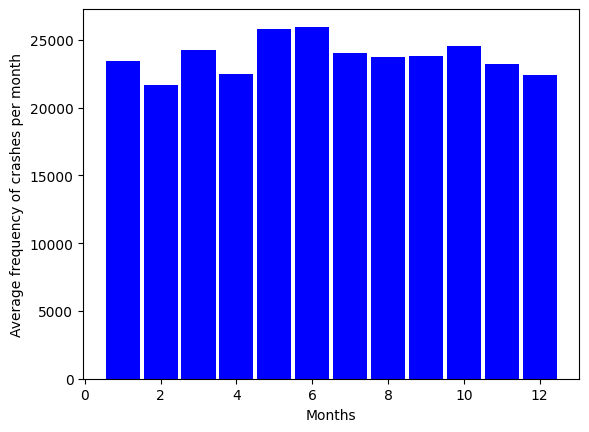

In [7]:
# observed values illustration
fig=go.Figure()
# Add line trace
fig.add_trace(go.Scatter(x=agg2.index.to_timestamp(), y=agg['CRASH TIME'], mode='lines', name='Line'))
# Show the interactive plot
fig.show()

# bar plot for average frequency of crashes per month
agg1=data.groupby('month of crash').count()
a=list(agg1['CRASH DATE'])
for i in range(6):
    a[i]=a[i]/7
for i in range(6,12):
    a[i]=a[i]/8
plt.bar(agg1.index, a, width=0.9, alpha=1, color='blue')
plt.xlabel('Months')
plt.ylabel('Average frequency of crashes per month')

# New York's crashes density map
# Change the year as you wish, setting any value in the interval[2012,2019]
df = data[data['year']==2018]
df=df[df['LATITUDE'].notna() & df['LONGITUDE'].notna()]
# Create the map centered on New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=17)
# Prepare the data for the heatmap
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(m)
m

## Task 3. Decomposition

Seed set to 42 for reproducibility.


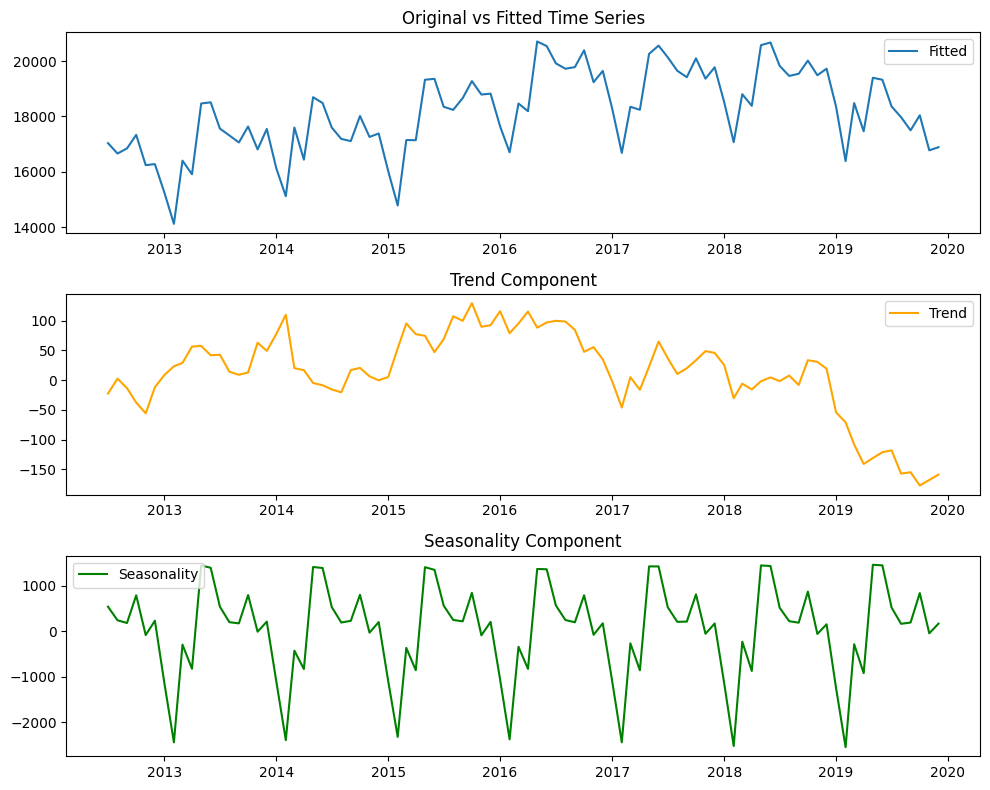

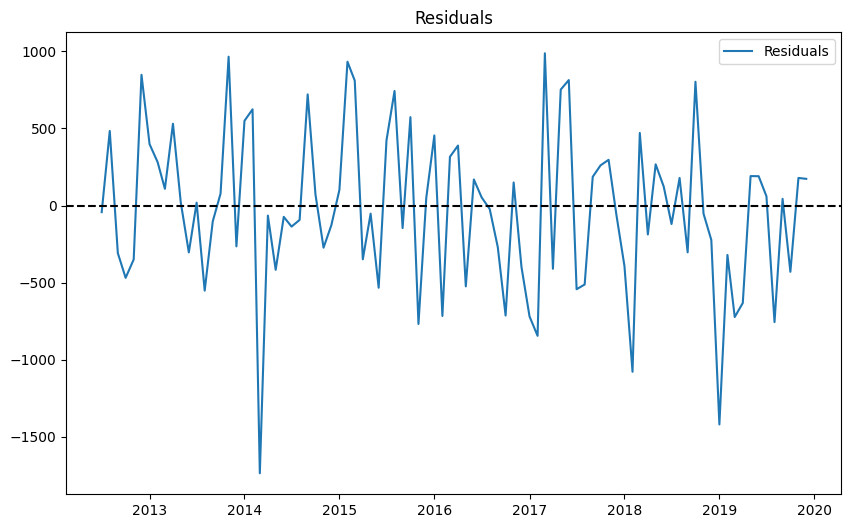

In [8]:
set_seed(42)

model = ExponentialSmoothing(agg2['CRASH TIME'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Get the components
fitted_values = fit.fittedvalues
trend_component = fit.trend
seasonal_component = fit.season
residuals = fit.resid
# Plot the components
plt.figure(figsize=(10, 8))

# Plot Original Time Series and the Fitted Values
plt.subplot(3, 1, 1)
plt.plot(fitted_values.index.to_timestamp(), fitted_values, label='Fitted')
plt.title('Original vs Fitted Time Series')
plt.legend()

# Plot Trend Component
plt.subplot(3, 1, 2)
plt.plot(trend_component.index.to_timestamp(), trend_component, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Plot Seasonal Component
plt.subplot(3, 1, 3)
plt.plot(seasonal_component.index.to_timestamp(), seasonal_component, label='Seasonality', color='green')
plt.title('Seasonality Component')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.plot(agg2.index.to_timestamp(), residuals, label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals')
plt.legend()
plt.show()

# Task 5 CatBoost

**CatBoost (Gradient Boosting)** outperforms **Random Forest** on crash count data:

### **1. Sequential Learning and Error Correction**
It appears that CatBoost's sequential approach enables it to model dependencies more accurately, leading to better performance on complex datasets.
### **2. Handling of Categorical Features**
We suppose that CatBoost's native handling of categorical data reduces preprocessing efforts and maintains feature integrity, giving it an edge over Random Forest.
### **3. Enhanced Regularization and Overfitting Prevention**
CatBoost's sophisticated regularization strategies allow it to generalize better, especially in our dataset where overfitting is a concern.

Seed set to 42 for reproducibility.


[I 2024-12-31 20:28:59,727] A new study created in memory with name: NYC_Crash_Predictions
[I 2024-12-31 20:29:00,106] Trial 0 finished with value: 72.02841653564255 and parameters: {'iterations': 3000, 'depth': 5, 'learning_rate': 0.06717861063145893, 'l2_leaf_reg': 2.3972353380543523, 'random_strength': 6.1308414834868845, 'border_count': 35, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'od_pval': 0.11331406954081512}. Best is trial 0 with value: 72.02841653564255.
[I 2024-12-31 20:29:00,172] Trial 1 finished with value: 72.3678065116692 and parameters: {'iterations': 4000, 'depth': 6, 'learning_rate': 0.25911844651253274, 'l2_leaf_reg': 1.6991605138861956, 'random_strength': 0.28623862168027747, 'border_count': 86, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 29, 'od_pval': 0.050558139726759696}. Best is trial 0 with value: 72.02841653564255.
[I 2024-12-31 20:29:01,959] Trial 2 finished with value: 70.89021518530873 and parameters: {'iterations': 3000, 'depth': 8, 'lear

Best Trial on Validation Set:
  Val RMSE: 69.84247202066754
  Params: {'iterations': 3000, 'depth': 8, 'learning_rate': 0.02037317961838218, 'l2_leaf_reg': 0.034568174779737185, 'random_strength': 1.6124926979253742, 'border_count': 200, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 23, 'od_pval': 0.009766159865002394}
0:	learn: 100.5616173	total: 2.1ms	remaining: 6.3s
1:	learn: 99.6344774	total: 3.8ms	remaining: 5.69s
2:	learn: 98.8286781	total: 5.25ms	remaining: 5.25s
3:	learn: 97.9143319	total: 6.63ms	remaining: 4.96s
4:	learn: 97.0072918	total: 8.02ms	remaining: 4.8s
5:	learn: 96.1823804	total: 9.38ms	remaining: 4.68s
6:	learn: 95.3614860	total: 10.7ms	remaining: 4.58s
7:	learn: 94.5837168	total: 12.1ms	remaining: 4.53s
8:	learn: 93.8177056	total: 13.5ms	remaining: 4.5s
9:	learn: 93.0167164	total: 14.9ms	remaining: 4.45s
10:	learn: 92.2544666	total: 16.3ms	remaining: 4.42s
11:	learn: 91.4667397	total: 17.7ms	remaining: 4.4s
12:	learn: 90.7993425	total: 19ms	remaining: 4.37s
1

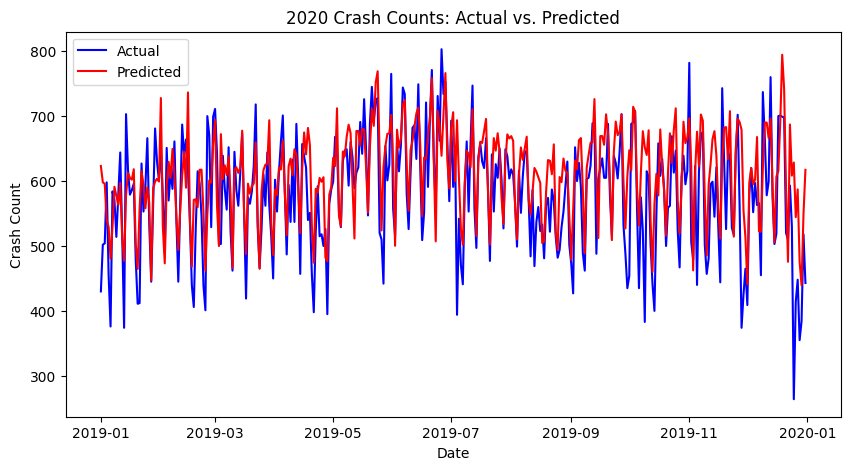

In [9]:
set_seed(42)

#----------------------------------------------------------
# Load and Preprocess Data
#----------------------------------------------------------

df = pd.read_csv(
    'Motor_Vehicle_Collisions_-_Crashes_20241206.csv',
    parse_dates=['CRASH DATE'],
    low_memory=False
)
df = df.sort_values('CRASH DATE')

daily_df = df.groupby('CRASH DATE').size().reset_index(name='crash_count')
all_days = pd.date_range(
    start=daily_df['CRASH DATE'].min(),
    end=daily_df['CRASH DATE'].max(),
    freq='D'
)
daily_df = (
    daily_df.set_index('CRASH DATE')
    .reindex(all_days, fill_value=0)
    .rename_axis('date')
    .reset_index()
)

#----------------------------------------------------------
# Minimal Feature Engineering (Time-based + Lags)
#----------------------------------------------------------

daily_df['year'] = daily_df['date'].dt.year
daily_df['month'] = daily_df['date'].dt.month
daily_df['day_of_week'] = daily_df['date'].dt.dayofweek

for lag in range(1, 8):
    daily_df[f'lag_{lag}'] = daily_df['crash_count'].shift(lag)

daily_df.fillna(0, inplace=True)

#----------------------------------------------------------
# Time-based Split: Train / Val / Test
#   Train: up to 2018-12-31
#   Val:   2019-01-01 to 2019-12-31
#   Test:  2020-01-01 to 2020-12-31
#----------------------------------------------------------

train_end = pd.to_datetime('2017-12-31')
val_end   = pd.to_datetime('2018-12-31')
test_end  = pd.to_datetime('2019-12-31')

train_data = daily_df[daily_df['date'] <= train_end]
val_data   = daily_df[(daily_df['date'] > train_end) & (daily_df['date'] <= val_end)]
test_data  = daily_df[(daily_df['date'] > val_end) & (daily_df['date'] <= test_end)]

X_train = train_data.drop(columns=['date', 'crash_count'])
y_train = train_data['crash_count']
X_val   = val_data.drop(columns=['date', 'crash_count'])
y_val   = val_data['crash_count']
X_test  = test_data.drop(columns=['date', 'crash_count'])
y_test  = test_data['crash_count']

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)
test_pool  = Pool(X_test, y_test)

#----------------------------------------------------------
# Optuna Objective Function
#----------------------------------------------------------

def objective(trial):
    iterations = trial.suggest_int('iterations', 1000, 8000, step=1000)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)
    random_strength = trial.suggest_float('random_strength', 0.1, 10.0, log=True)
    border_count = trial.suggest_int('border_count', 32, 255)
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 50)
    od_pval = trial.suggest_float('od_pval', 0.001, 0.5, log=True)

    model = CatBoostRegressor(
        task_type='CPU',
        devices='0',
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        border_count=border_count,
        grow_policy=grow_policy,
        min_data_in_leaf=min_data_in_leaf,
        od_type='Iter',
        od_pval=od_pval,
        loss_function='RMSE',
        verbose=False
    )

    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, use_best_model=True)
    val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
    return rmse_val

#----------------------------------------------------------
# Run Optuna Hyperparameter Tuning
#----------------------------------------------------------
study = optuna.create_study(
    direction='minimize',
    pruner=HyperbandPruner(),
    study_name='NYC_Crash_Predictions'
)
study.optimize(objective, n_trials=100)

print("Best Trial on Validation Set:")
best_trial = study.best_trial
print("  Val RMSE:", best_trial.value)
print("  Params:", best_trial.params)

#----------------------------------------------------------
# Save the best parameters to a file named best_optuna_parameters
#----------------------------------------------------------
with open("best_optuna_parameters.json", "w") as f:
    json.dump(best_trial.params, f, indent=4)

#----------------------------------------------------------
# Final Model Using Best Hyperparams
# Retrain on (Train + Val) then Evaluate on Test
#----------------------------------------------------------

best_params = best_trial.params

final_model_params = {
    'task_type': 'CPU',
    'devices': '0',
    'iterations': best_params.get('iterations', 2000),
    'depth': best_params.get('depth', 6),
    'learning_rate': best_params.get('learning_rate', 0.1),
    'l2_leaf_reg': best_params.get('l2_leaf_reg', 3.0),
    'random_strength': best_params.get('random_strength', 1.0),
    'border_count': best_params.get('border_count', 128),
    'grow_policy': best_params.get('grow_policy', 'SymmetricTree'),
    'min_data_in_leaf': best_params.get('min_data_in_leaf', 1),
    'od_type': 'Iter',
    'od_pval': best_params.get('od_pval', 0.01),
    'loss_function': 'RMSE',
    'verbose': True
}

final_model = CatBoostRegressor(**final_model_params)

combined_train_val = pd.concat([train_data, val_data], ignore_index=True)
X_combined = combined_train_val.drop(columns=['date', 'crash_count'])
y_combined = combined_train_val['crash_count']
combined_pool = Pool(X_combined, y_combined)

final_model.fit(combined_pool, early_stopping_rounds=50, use_best_model=False)

test_pred = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test RMSE (2020):", rmse_test)

plt.figure(figsize=(10, 5))
plt.plot(test_data['date'], y_test, label='Actual', color='blue')
plt.plot(test_data['date'], test_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.title('2019 Crash Counts: Actual vs. Predicted')
plt.legend()
plt.show()

Seed set to 42 for reproducibility.


[I 2024-12-31 20:30:30,092] A new study created in memory with name: NYC_Monthly_Crash_Predictions
[I 2024-12-31 20:30:30,216] Trial 0 finished with value: 463.7482774699729 and parameters: {'iterations': 6000, 'depth': 6, 'learning_rate': 0.013959906143827411, 'l2_leaf_reg': 0.00976137935922887, 'random_strength': 1.0504926874482503, 'border_count': 60, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 47, 'od_pval': 0.022678159609017264}. Best is trial 0 with value: 463.7482774699729.
[I 2024-12-31 20:30:35,581] Trial 1 finished with value: 449.18165659966394 and parameters: {'iterations': 7000, 'depth': 6, 'learning_rate': 0.0019133898097089645, 'l2_leaf_reg': 0.017053571280196272, 'random_strength': 0.1355573432337656, 'border_count': 217, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'od_pval': 0.00283118248204605}. Best is trial 1 with value: 449.18165659966394.
[I 2024-12-31 20:30:35,624] Trial 2 finished with value: 334.6412346149789 and parameters: {'iterations': 1000, 'dep

Best Trial on Validation Set:
  Val RMSE: 186.5212522349453
  Params: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.2799906421096229, 'l2_leaf_reg': 9.549974814381367, 'random_strength': 0.3351300948553375, 'border_count': 157, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 42, 'od_pval': 0.005028659638444408}
0:	learn: 1333.9396616	test: 1488.7961377	best: 1488.7961377 (0)	total: 254us	remaining: 254ms
1:	learn: 1180.2642146	test: 1289.0262567	best: 1289.0262567 (1)	total: 448us	remaining: 224ms
2:	learn: 1051.0122273	test: 1131.4955728	best: 1131.4955728 (2)	total: 612us	remaining: 204ms
3:	learn: 949.0809599	test: 1017.1988829	best: 1017.1988829 (3)	total: 777us	remaining: 194ms
4:	learn: 876.5146237	test: 932.2152027	best: 932.2152027 (4)	total: 932us	remaining: 186ms
5:	learn: 814.8862149	test: 848.3003039	best: 848.3003039 (5)	total: 1.13ms	remaining: 188ms
6:	learn: 765.6697797	test: 775.7873080	best: 775.7873080 (6)	total: 1.32ms	remaining: 187ms
7:	learn: 717.8733349	te

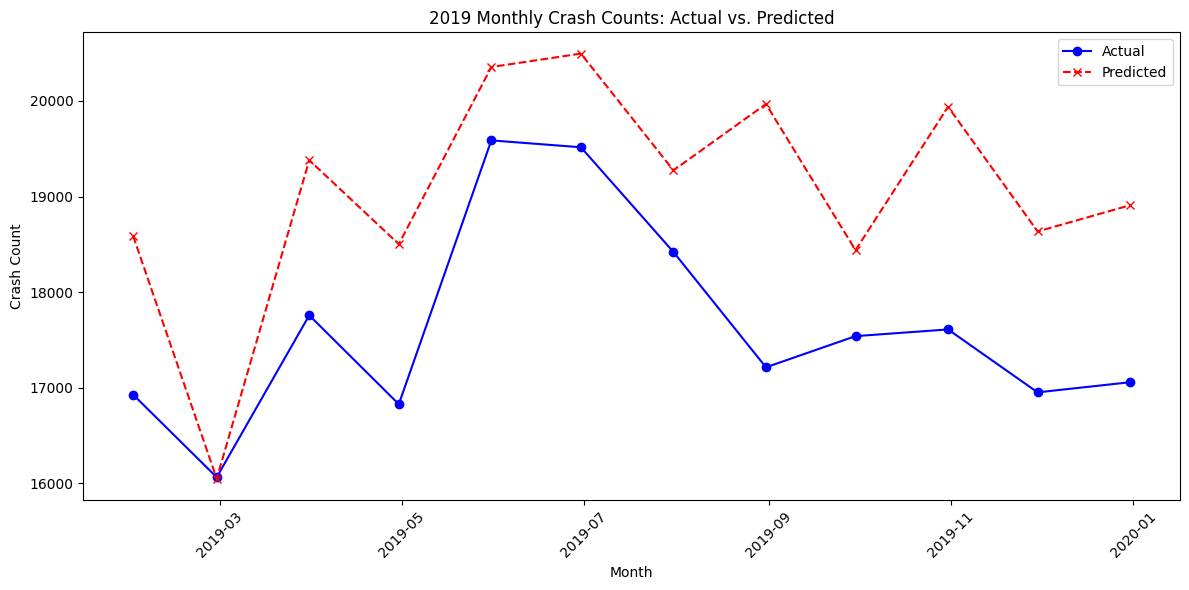

In [10]:
set_seed(42)

df = pd.read_csv(
    'Motor_Vehicle_Collisions_-_Crashes_20241206.csv',
    parse_dates=['CRASH DATE'],
    low_memory=False
)

df = df.sort_values('CRASH DATE')

monthly_df = df.resample('M', on='CRASH DATE').size().reset_index(name='crash_count')

all_months = pd.date_range(
    start=monthly_df['CRASH DATE'].min(),
    end=monthly_df['CRASH DATE'].max(),
    freq='M'
)
monthly_df = (
    monthly_df.set_index('CRASH DATE')
    .reindex(all_months, fill_value=0)
    .rename_axis('date')
    .reset_index()
)

#----------------------------------------------------------
# Feature Engineering: Time-based + Monthly Lags
#----------------------------------------------------------

monthly_df['year'] = monthly_df['date'].dt.year
monthly_df['month'] = monthly_df['date'].dt.month
monthly_df['quarter'] = monthly_df['date'].dt.quarter
monthly_df['day_of_week'] = monthly_df['date'].dt.dayofweek


lag_periods = [1, 2, 3, 4, 5, 6, 11, 12, 13, 24]
for lag in lag_periods:
    monthly_df[f'lag_{lag}'] = monthly_df['crash_count'].shift(lag)

monthly_df.fillna(0, inplace=True)

#----------------------------------------------------------
# Train/Validation/Test Split (Time-based)
#   Train: up to 2017-12
#   Val:   2018-01 to 2018-12
#   Test:  2019-01 to 2019-12
#----------------------------------------------------------

train_end = pd.to_datetime('2017-12-31')
val_end   = pd.to_datetime('2018-12-31')
test_end  = pd.to_datetime('2019-12-31')

train_data = monthly_df[monthly_df['date'] <= train_end]
val_data   = monthly_df[(monthly_df['date'] > train_end) & (monthly_df['date'] <= val_end)]
test_data  = monthly_df[(monthly_df['date'] > val_end) & (monthly_df['date'] <= test_end)]

feature_cols = [col for col in monthly_df.columns if col not in ['date', 'crash_count']]

X_train = train_data[feature_cols]
y_train = train_data['crash_count']
X_val   = val_data[feature_cols]
y_val   = val_data['crash_count']
X_test  = test_data[feature_cols]
y_test  = test_data['crash_count']

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)
test_pool  = Pool(X_test, y_test)

#----------------------------------------------------------
# Optuna Objective Function for Hyperparameter Tuning
#----------------------------------------------------------

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 8000, step=1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'od_pval': trial.suggest_float('od_pval', 0.001, 0.5, log=True)
    }

    model = CatBoostRegressor(
        task_type='CPU',
        devices='0',
        loss_function='RMSE',
        verbose=False,
        **params,
        od_type='Iter'
    )

    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        use_best_model=True
    )

    val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))

    return rmse_val

#----------------------------------------------------------
# Run Optuna Hyperparameter Tuning
#----------------------------------------------------------

study = optuna.create_study(
    direction='minimize',
    pruner=HyperbandPruner(),
    study_name='NYC_Monthly_Crash_Predictions'
)

study.optimize(objective, n_trials=100, timeout=None)

print("Best Trial on Validation Set:")
best_trial = study.best_trial
print(f"  Val RMSE: {best_trial.value}")
print(f"  Params: {best_trial.params}")

#----------------------------------------------------------
# Save the Best Hyperparameters to a JSON File
#----------------------------------------------------------
with open("best_optuna_parameters.json", "w") as f:
    json.dump(best_trial.params, f, indent=4)

#----------------------------------------------------------
# Final Model Training and Evaluation on Test Set
#----------------------------------------------------------

best_params = best_trial.params

final_model_params = {
    'task_type': 'CPU',
    'devices': '0',
    'loss_function': 'RMSE',
    'verbose': True,
    'od_type': 'Iter'
}

final_model_params.update(best_params)

final_model = CatBoostRegressor(**final_model_params)

combined_train_val = pd.concat([train_data, val_data], ignore_index=True)
X_combined = combined_train_val[feature_cols]
y_combined = combined_train_val['crash_count']
combined_pool = Pool(X_combined, y_combined)

final_model.fit(
    combined_pool,
    eval_set=val_pool,
    early_stopping_rounds=50,
    use_best_model=True
)

test_pred = final_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE (2019): {rmse_test}")

#----------------------------------------------------------
# Plot Actual vs Predicted Crash Counts for the Test Period
#----------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(test_data['date'], test_pred, label='Predicted', marker='x', linestyle='--', color='red')
plt.xlabel('Month')
plt.ylabel('Crash Count')
plt.title('2019 Monthly Crash Counts: Actual vs. Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 6 Enhanced LSTM + Compherehensive Feature Engeneering

This section outlines the key steps performed in the provided Python code to prepare and enhance the dataset for building an LSTM model aimed at predicting daily motor vehicle crash counts in New York City (NYC). The focus is on data preprocessing, feature engineering, and ensuring reproducibility and stability in the modeling process.

## 1. Load and Preprocess Data

### a. Load the Dataset
The motor vehicle collision data is loaded from a CSV file into a pandas DataFrame. The `CRASH DATE` column is parsed as datetime objects to facilitate time-based analyses. Sorting the DataFrame by `CRASH DATE` ensures that the data is in chronological order, essential for time series analysis.

### b. Borough Information
Missing values in the `BOROUGH` column are filled with `'Unknown'`. The `BOROUGH` data is one-hot encoded to convert categorical information into a numerical format suitable for model training. Crash counts are aggregated by date and borough, ensuring that every day up to December 31, 2019, is represented, with missing days filled with zeros.

### c. Temporal Features
Temporal features such as the day of the week and month are extracted and one-hot encoded to capture cyclical patterns. A binary feature indicating whether a day is a holiday in New York is added using the `holidays` library. These temporal features are then merged into the main dataset.

### d. Injury and Fatality Counts
Injury and fatality metrics are aggregated by date to quantify the severity of crashes. This includes totals for persons injured or killed, pedestrians injured or killed, cyclists injured or killed, and motorists injured or killed. The aggregated data is merged with the main dataset, ensuring completeness by filling missing dates with zeros.

## 2. Enhance Feature Engineering
### a. Rolling Statistics

A 7-day rolling average is calculated for each borough's crash counts to smooth out short-term fluctuations and highlight longer-term trends. This helps the model capture temporal dependencies more effectively.

### b. Lag Features

Lagged features are created to incorporate information from the past 7 days. This includes lagged crash counts and lagged injury/fatality counts, allowing the model to consider historical data when making predictions.

## 3. Handle Categorical Variables Appropriately
### a. Borough Indices

Each borough is assigned a unique integer index. For each day, the borough with the highest number of crashes (dominant borough) is identified and mapped to its corresponding index. Days with no specified boroughs are assigned an index of `-1` to indicate `'Unknown'`.

### b. Contributing Factors

Missing values in contributing factor columns are filled with `'Unspecified'`. The most common contributing factor for each day is identified and one-hot encoded, providing contextual information that can influence crash counts.

## 4. Feature Scaling and Sequence Creation
### a. Define Feature Columns

A comprehensive list of feature columns is compiled, including crash counts, borough indicators, temporal features, injury/fatality counts, rolling statistics, lagged features, and contributing factors.

### b. Scale Features

All features are scaled using `MinMaxScaler` to normalize their values between 0 and 1, which is beneficial for neural network training as it ensures that all features contribute equally to the learning process.

### c. Create Sequences for LSTM

Input-output sequences are created for the LSTM model. Each input sequence consists of 30 consecutive days of scaled data, and the corresponding target is the crash count on the day following the sequence. This setup allows the LSTM to learn temporal dependencies and patterns over the specified sequence length.

## 5. Time-Based Split: Train / Validation / Test
The dataset is split into training, validation, and test sets based on time to preserve the chronological order of the data:

- **Training Set:** Includes data up to December 31, 2017.
- **Validation Set:** Covers the entire year of 2018.
- **Test Set:** Encompasses the entire year of 2019.

## 6. Define PyTorch Dataset
A custom PyTorch `Dataset` class named `CrashDataset` is defined to handle the crash data. This class converts the input features and targets into PyTorch tensors, enabling efficient data loading and batching during model training and evaluation.

## 7. Define Enhanced LSTM Model Architecture
An LSTM-based neural network model named `EnhancedLSTMModel` is defined with configurable parameters:

- **Input Size:** Number of features per input sequence.
- **Hidden Size:** Number of units in the LSTM layers.
- **Number of Layers:** Depth of the LSTM network.
- **Dropout Rate:** Regularization parameter to prevent overfitting.
- **Bidirectional:** Indicates whether the LSTM is bidirectional.

## 8. Define Optuna Objective Function for Hyperparameter Tuning
An objective function is defined for Optuna, a hyperparameter optimization framework. This function specifies the hyperparameters to be tuned, including the number of LSTM units, dropout rate, learning rate, batch size, number of layers, and whether to use a bidirectional LSTM. The function trains the model using the training set, evaluates it on the validation set, and returns the validation RMSE. Early stopping is implemented to prevent overfitting and reduce computational time.

## 9. Run Optuna Hyperparameter Tuning
An Optuna study is initialized to minimize the validation RMSE using the Hyperband pruner for efficient optimization. The study runs for a specified number of trials (`50` in this case), exploring different combinations of hyperparameters to identify the optimal configuration. The best trial's results, including the validation RMSE and corresponding hyperparameters, are printed for reference.

## 10. Save the Best Hyperparameters to a JSON File
The best-found hyperparameters from the Optuna study are saved to a JSON file named `best_optuna_parameters_lstm_daily_enhanced.json`. This allows for easy reference and ensures that the optimal model configuration can be reproduced in future runs.

## 11. Final Model Training and Evaluation on Test Set
Using the best hyperparameters identified by Optuna, the final LSTM model is defined and trained on the combined training and validation sets. Early stopping is employed to halt training if no improvement is observed over a set number of epochs (`10` in this case). The best-performing model is saved for later use.

After training, the model generates predictions on the test set. These predictions and the actual crash counts are inverse-transformed to their original scale for meaningful evaluation. The Root Mean Squared Error (RMSE) on the test set is calculated to assess the model's performance.

## 12. Plot Actual vs. Predicted Crash Counts for the Test Period
Visualizations are created to compare the model's predictions against the actual crash counts for the year 2019. A plot shows the daily actual and predicted crash counts, providing a clear view of the model's accuracy over time. Additionally, a residuals plot displays the differences between actual and predicted values.

In [11]:
set_seed(42)

#----------------------------------------------------------
# 1. Load and Preprocess Data
#----------------------------------------------------------

df = pd.read_csv(
    'Motor_Vehicle_Collisions_-_Crashes_20241206.csv',
    parse_dates=['CRASH DATE'],
    low_memory=False
)

df = df.sort_values('CRASH DATE')
df['BOROUGH'] = df['BOROUGH'].fillna('Unknown')

#----------------------------------------------------------
# 2. Aggregate Daily Crash Counts and Borough Information
#----------------------------------------------------------

all_days = pd.date_range(start=df['CRASH DATE'].min(), end='2019-12-31', freq='D')

daily_borough_df = df.groupby(['CRASH DATE', 'BOROUGH']).size().unstack(fill_value=0)
daily_borough_df = daily_borough_df.reindex(all_days, fill_value=0).rename_axis('date').reset_index()

if 'Unknown' not in daily_borough_df.columns:
    daily_borough_df['Unknown'] = 0

#----------------------------------------------------------
# 3. Add Temporal Features
#----------------------------------------------------------

daily_borough_df['day_of_week'] = daily_borough_df['date'].dt.dayofweek
daily_borough_df['month'] = daily_borough_df['date'].dt.month

day_dummies = pd.get_dummies(daily_borough_df['day_of_week'], prefix='day')
month_dummies = pd.get_dummies(daily_borough_df['month'], prefix='month')

ny_holidays = holidays.US(state='NY')
print(ny_holidays)
daily_borough_df['is_holiday'] = daily_borough_df['date'].isin(ny_holidays).astype(int)

daily_features = pd.concat([daily_borough_df, day_dummies, month_dummies], axis=1)

#----------------------------------------------------------
# 4. Aggregate Injury and Fatality Counts
#----------------------------------------------------------

injury_fatality_cols = [
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED',
    'NUMBER OF MOTORIST KILLED'
]

injury_fatality_df = df.groupby('CRASH DATE')[injury_fatality_cols].sum()
injury_fatality_df = injury_fatality_df.reindex(all_days, fill_value=0)
injury_fatality_df = injury_fatality_df.rename_axis('date').reset_index()

daily_features = pd.merge(daily_features, injury_fatality_df, on='date', how='left')

#----------------------------------------------------------
# 5. Create Rolling Statistics and Lag Features
#----------------------------------------------------------

borough_columns = [col for col in daily_borough_df.columns if col.startswith('BOROUGH_') or col == 'Unknown']
crash_count = daily_borough_df[borough_columns].sum(axis=1)
crash_count_roll_mean = crash_count.rolling(window=7).mean().fillna(0)

num_lags = 7

crash_count_lags = pd.concat(
    [crash_count.shift(lag).fillna(0).rename(f'crash_count_lag_{lag}') for lag in range(1, num_lags + 1)], axis=1)

injury_fatality_lags = pd.concat([
    injury_fatality_df[col].shift(lag).fillna(0).rename(f'{col}_lag_{lag}')
    for col in injury_fatality_cols for lag in range(1, num_lags + 1)], axis=1)

new_features = pd.concat([crash_count, crash_count_roll_mean, crash_count_lags, injury_fatality_lags], axis=1)
new_features.columns = (
    ['crash_count', 'crash_count_7d_roll_mean'] +
    list(crash_count_lags.columns) +
    list(injury_fatality_lags.columns))

daily_features = pd.concat([daily_features, new_features], axis=1).fillna(0)

#----------------------------------------------------------
# 6. Handle Categorical Variables
#----------------------------------------------------------

dominant_borough = daily_features[borough_columns].idxmax(axis=1).str.replace('BOROUGH_', '')
dominant_borough = dominant_borough.replace('Unknown', 'Unknown')

borough_categories = df['BOROUGH'].unique().tolist()
borough_to_idx = {borough: idx for idx, borough in enumerate(borough_categories)}
borough_idx = dominant_borough.map(borough_to_idx).fillna(-1).astype(int)

categorical_features = pd.DataFrame({
    'dominant_borough': dominant_borough,
    'borough_idx': borough_idx
})

daily_features = pd.concat([daily_features, categorical_features], axis=1)

#----------------------------------------------------------
# 7. Incorporate Contributing Factors
#----------------------------------------------------------

contrib_cols = [
    'CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3',
    'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5'
]
df[contrib_cols] = df[contrib_cols].fillna('Unspecified')

factors_daily = df.groupby('CRASH DATE')['CONTRIBUTING FACTOR VEHICLE 1'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unspecified'
).reset_index()

factors_dummies = pd.get_dummies(factors_daily['CONTRIBUTING FACTOR VEHICLE 1'], prefix='factor')
factors_dummies['date'] = factors_daily['CRASH DATE']
factors_dummies = factors_dummies.set_index('date').reindex(all_days, fill_value=0).reset_index().rename(columns={'index': 'date'})

daily_features = pd.concat([daily_features, factors_dummies.drop('date', axis=1)], axis=1).fillna(0)
daily_features = daily_features.copy()

#----------------------------------------------------------
# 8. Feature Scaling and Sequence Creation
#----------------------------------------------------------

feature_columns = (
    ['crash_count', 'crash_count_7d_roll_mean'] +
    [f'crash_count_lag_{lag}' for lag in range(1, num_lags + 1)] +
    injury_fatality_cols +
    [f'{col}_lag_{lag}' for col in injury_fatality_cols for lag in range(1, num_lags + 1)] +
    ['is_holiday'] +
    list(day_dummies.columns) +
    list(month_dummies.columns) +
    list(factors_dummies.columns.drop('date')))

ts_features = daily_features[feature_columns].astype(float)

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_features)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(ts_scaled, SEQ_LENGTH)

#----------------------------------------------------------
# 9. Time-based Split: Train / Val / Test
#----------------------------------------------------------

y_dates = daily_features['date'][SEQ_LENGTH:].reset_index(drop=True)

train_end = pd.to_datetime('2017-12-31')
val_end = pd.to_datetime('2018-12-31')
test_end = pd.to_datetime('2019-12-31')

train_mask = y_dates <= train_end
val_mask = (y_dates > train_end) & (y_dates <= val_end)
test_mask = (y_dates > val_end) & (y_dates <= test_end)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Seed set to 42 for reproducibility.
{'country': US, 'expand': True, 'language': None, 'market': None, 'observed': True, 'subdiv': NY, 'years': set()}
Training set: 1980 samples
Validation set: 365 samples
Test set: 365 samples


In [12]:
print("\nSelected Feature Columns:")
print(feature_columns)


Selected Feature Columns:
['crash_count', 'crash_count_7d_roll_mean', 'crash_count_lag_1', 'crash_count_lag_2', 'crash_count_lag_3', 'crash_count_lag_4', 'crash_count_lag_5', 'crash_count_lag_6', 'crash_count_lag_7', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'NUMBER OF PERSONS INJURED_lag_1', 'NUMBER OF PERSONS INJURED_lag_2', 'NUMBER OF PERSONS INJURED_lag_3', 'NUMBER OF PERSONS INJURED_lag_4', 'NUMBER OF PERSONS INJURED_lag_5', 'NUMBER OF PERSONS INJURED_lag_6', 'NUMBER OF PERSONS INJURED_lag_7', 'NUMBER OF PERSONS KILLED_lag_1', 'NUMBER OF PERSONS KILLED_lag_2', 'NUMBER OF PERSONS KILLED_lag_3', 'NUMBER OF PERSONS KILLED_lag_4', 'NUMBER OF PERSONS KILLED_lag_5', 'NUMBER OF PERSONS KILLED_lag_6', 'NUMBER OF PERSONS KILLED_lag_7', 'NUMBER OF PEDESTRIANS INJURED_lag_1', 'NUMBER OF PEDESTRIANS

In [13]:
print("\nAggregated Crash Counts by Date and Borough:")
daily_borough_df.head()


Aggregated Crash Counts by Date and Borough:


BOROUGH       date  BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND  \
0       2012-07-01     39       135        119     101             26   
1       2012-07-02     71       140        113      94             25   
2       2012-07-03     73       167        150     136             22   
3       2012-07-04     51        94         65      93             22   
4       2012-07-05     60       153        107     123             24   

BOROUGH  Unknown  day_of_week  month  is_holiday  
0            118            6      7           0  
1            121            0      7           0  
2            116            1      7           0  
3            107            2      7           0  
4            124            3      7           0

In [14]:
print("\nDaily Features with Contributing Factors:")
daily_features.head(5)


Daily Features with Contributing Factors:


date  BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND  Unknown  \
0 2012-07-01     39       135        119     101             26      118   
1 2012-07-02     71       140        113      94             25      121   
2 2012-07-03     73       167        150     136             22      116   
3 2012-07-04     51        94         65      93             22      107   
4 2012-07-05     60       153        107     123             24      124   

   day_of_week  month  is_holiday  ...  NUMBER OF MOTORIST KILLED_lag_3  \
0            6      7           0  ...                              0.0   
1            0      7           0  ...                              0.0   
2            1      7           0  ...                              0.0   
3            2      7           0  ...                              0.0   
4            3      7           0  ...                              1.0   

   NUMBER OF MOTORIST KILLED_lag_4  NUMBER OF MOTORIST KILLED_lag_5  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   NUMBER OF MOTORIST KILLED_lag_6  NUMBER OF MOTORIST KILLED_lag_7  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   dominant_borough  borough_idx  factor_Driver Inattention/Distraction  \
0           Unknown            2                                  False   
1           Unknown            2                                  False   
2           Unknown            2                                  False   
3           Unknown            2                                  False   
4           Unknown            2                                  False   

   factor_Pavement Slippery  factor_Unspecified  
0                     False                True  
1                     False                True  
2                     False                True  
3                     False                True  
4                     False                True  

[5 rows x 107 columns]

In [15]:
print("\nBorough to Index Mapping:")
print(borough_to_idx)
print("\nDaily Features with Borough Indices:")
daily_features[['date', 'dominant_borough', 'borough_idx']].head()


Borough to Index Mapping:
{'STATEN ISLAND': 0, 'BRONX': 1, 'Unknown': 2, 'BROOKLYN': 3, 'QUEENS': 4, 'MANHATTAN': 5}

Daily Features with Borough Indices:


date dominant_borough  borough_idx
0 2012-07-01          Unknown            2
1 2012-07-02          Unknown            2
2 2012-07-03          Unknown            2
3 2012-07-04          Unknown            2
4 2012-07-05          Unknown            2

[I 2024-12-31 20:30:56,372] A new study created in memory with name: NYC_Crash_Predictions_LSTM_Daily_Enhanced


Seed set to 42 for reproducibility.
Enhanced LSTM Model Defined.


[I 2024-12-31 20:31:05,883] Trial 0 finished with value: 0.06616332350295676 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.005614430606827821, 'batch_size': 8, 'num_layers': 1, 'weight_decay': 1.6807349852444137e-05}. Best is trial 0 with value: 0.06616332350295676.
[I 2024-12-31 20:31:11,735] Trial 1 finished with value: 0.06447444273626353 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.003734512573928231, 'batch_size': 16, 'num_layers': 2, 'weight_decay': 0.00036536944262016957}. Best is trial 1 with value: 0.06447444273626353.
[I 2024-12-31 20:31:17,257] Trial 2 finished with value: 0.059714738252254665 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0007319862597081062, 'batch_size': 32, 'num_layers': 1, 'weight_decay': 0.0005148149225008133}. Best is trial 2 with value: 0.059714738252254665.
[I 2024-12-31 20:31:32,490] Trial 3 finished with value: 0.06087352038296944 and parameters: {'lstm_units':


Best Trial on Validation Set:
Val RMSE: 0.0573
Params: {'lstm_units': 128, 'dropout_rate': 0.05, 'learning_rate': 0.0001502608401663184, 'batch_size': 16, 'num_layers': 1, 'weight_decay': 2.5693210984027717e-05}

Test RMSE (2019): 32.7393

Test MAPE (2019): 0.1355


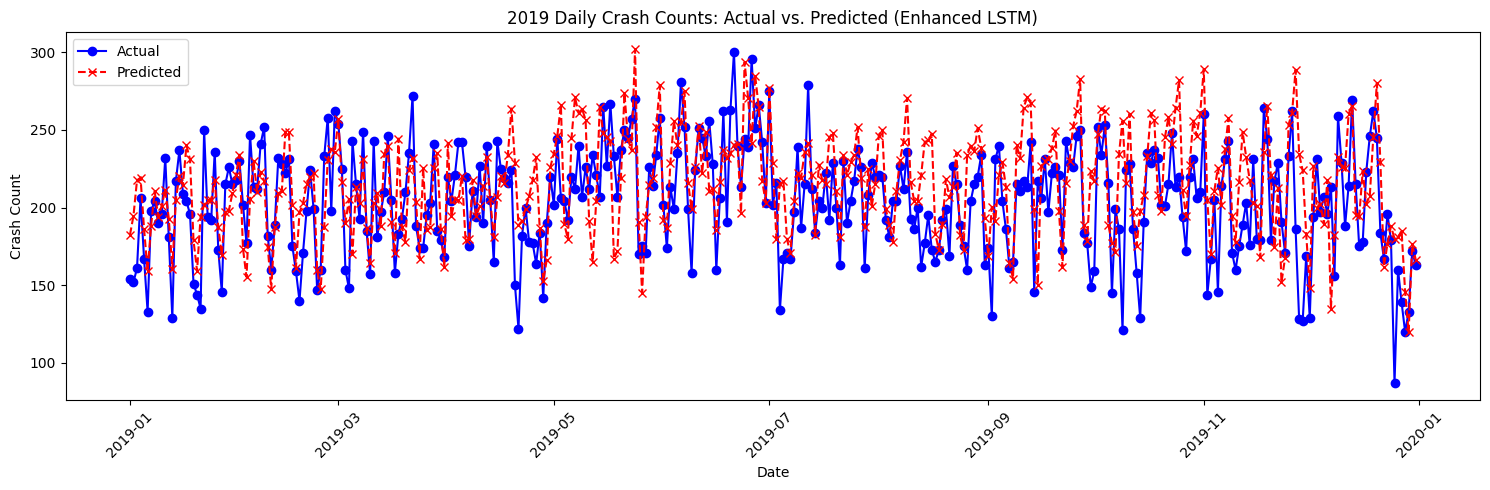

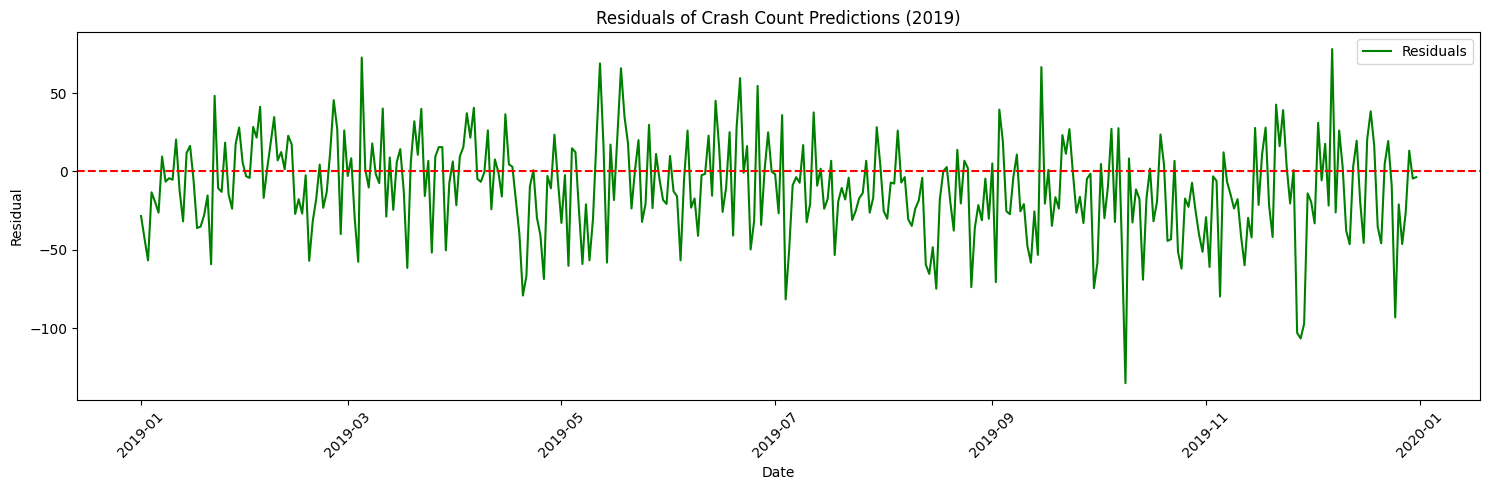

In [16]:
set_seed(42)

#----------------------------------------------------------
# Define PyTorch Dataset
#----------------------------------------------------------

class CrashDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#----------------------------------------------------------
# Define Enhanced LSTM Model Architecture
#----------------------------------------------------------

class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, bidirectional=False):
        super(EnhancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze()

print("Enhanced LSTM Model Defined.")

#----------------------------------------------------------
# Define Optuna Objective Function for Hyperparameter Tuning
#----------------------------------------------------------

def objective(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 160, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 32, step=8)
    num_layers = trial.suggest_int('num_layers', 1, 2)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    bidirectional = False

    train_dataset = CrashDataset(X_train, y_train)
    val_dataset = CrashDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = EnhancedLSTMModel(
        input_size=X_train.shape[2],
        hidden_size=lstm_units,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.MSELoss()

    epochs = 100
    patience = 15
    best_val_rmse = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(batch_y.cpu().numpy())

        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        scheduler.step(val_rmse)

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    return best_val_rmse

#----------------------------------------------------------
# Run Optuna Hyperparameter Tuning
#----------------------------------------------------------

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='NYC_Crash_Predictions_LSTM_Daily_Enhanced'
)

study.optimize(objective, n_trials=50, timeout=1800)

print("\nBest Trial on Validation Set:")
best_trial = study.best_trial
print(f"Val RMSE: {best_trial.value:.4f}")
print(f"Params: {best_trial.params}")

#----------------------------------------------------------
# Save the Best Hyperparameters to a JSON File
#----------------------------------------------------------
with open("best_optuna_parameters_lstm_daily_enhanced.json", "w") as f:
    json.dump(best_trial.params, f, indent=4)

#----------------------------------------------------------
# Final Model Training and Evaluation on Test Set
#----------------------------------------------------------

X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

train_val_dataset = CrashDataset(X_train_val, y_train_val)
test_dataset = CrashDataset(X_test, y_test)

train_val_loader = DataLoader(train_val_dataset, batch_size=best_trial.params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_trial.params['batch_size'], shuffle=False)

final_model = EnhancedLSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_trial.params['lstm_units'],
    num_layers=best_trial.params['num_layers'],
    dropout_rate=best_trial.params['dropout_rate'],
    bidirectional=False).to(device)

final_optimizer = torch.optim.AdamW(
    final_model.parameters(),
    lr=best_trial.params['learning_rate'],
    weight_decay=best_trial.params['weight_decay'])

final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.5,
    patience=3)

final_criterion = nn.MSELoss()

epochs = 100
patience = 15
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    final_model.train()
    for batch_X, batch_y in train_val_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        final_optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = final_criterion(outputs, batch_y)
        loss.backward()
        final_optimizer.step()

    final_model.eval()
    train_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in train_val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = final_model(batch_X)
            loss = final_criterion(outputs, batch_y)
            train_loss += loss.item()

    train_loss /= len(train_val_loader)
    final_scheduler.step(train_loss)

    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), 'best_model_enhanced.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            final_model.load_state_dict(torch.load('best_model_enhanced.pth'))
            print(f"Early stopping at epoch {epoch+1}")
            break

#----------------------------------------------------------
# Evaluate on Test Set
#----------------------------------------------------------

final_model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = final_model(batch_X)
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())


crash_count_index = feature_columns.index('crash_count')

crash_count_min = scaler.data_min_[crash_count_index]
crash_count_max = scaler.data_max_[crash_count_index]

test_pred_actual = np.array(test_preds) * (crash_count_max - crash_count_min) + crash_count_min
y_test_actual = np.array(test_targets) * (crash_count_max - crash_count_min) + crash_count_min

rmse_test = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))
mape_test = mean_absolute_percentage_error(y_test_actual, test_pred_actual)
print(f"\nTest RMSE (2019): {rmse_test:.4f}")
print(f"\nTest MAPE (2019): {mape_test:.4f}")

#----------------------------------------------------------
# Plot Actual vs Predicted Crash Counts for the Test Period
#----------------------------------------------------------

plt.figure(figsize=(15, 5))
plt.plot(
    y_dates[test_mask],
    y_test_actual,
    label='Actual',
    marker='o',
    linestyle='-',
    color='blue')
plt.plot(
    y_dates[test_mask],
    test_pred_actual,
    label='Predicted',
    marker='x',
    linestyle='--',
    color='red')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.title('2019 Daily Crash Counts: Actual vs. Predicted (Enhanced LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Plot Residuals
#----------------------------------------------------------

residuals = y_test_actual - test_pred_actual
plt.figure(figsize=(15, 5))
plt.plot(
    y_dates[test_mask],
    residuals,
    label='Residuals',
    color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals of Crash Count Predictions (2019)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 5. ETS
## 1. ExponentialSmoothing
This model was chosen as a popular time series forecasting method known for its simplicity and accuracy in predicting future trends based on historical data. According to the metrics this ETS model presented a moderate quality forecast with RMSE=2189 and MAPE=0.119
## 2. AutoCES
This model was chose as kind of more complicated model, where CES stands for Complex Exponential Smoothing model. However, it's turned out to perform even worse than the previous method.
## 3. Prophet
Finally, Prophet being the modernised ETS model, as being expected, demonstrated the highest perfomance among the listed ETS models

Seed set to 42 for reproducibility.


20:43:15 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing


exponential smoothing rmse: 2278.1613209566817, prophet rmse: 2129.2575998975126, autoces rmse:2231.3611304725746
exponential smoothing mape: 0.12467614445414266, prophet rmse: 0.1104078726459538, autoces rmse:0.11629921535694526


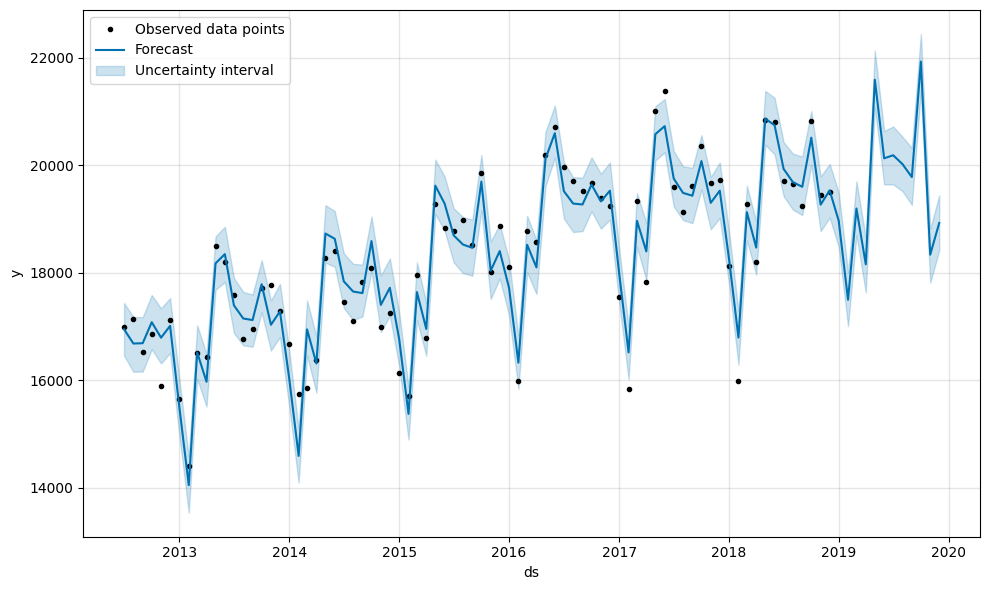

In [17]:
set_seed(42)

# creating train and test values
train1=agg[(agg['month and year']<='2018-12')]
train1.reset_index(inplace=True)
train1=train1[['month and year of crash','CRASH DATE']]
trin1=train1.columns=['ds','y']
train1['ds']=train1['ds'].dt.to_timestamp()
train=agg[(agg['month and year']<='2018-12')]
actual=agg[(agg['month and year']<='2019-12')]
actualfut=agg[(agg['month and year']<='2019-12') & (agg['month and year']>'2018-12')]


# ExponentialSmoothing
model = ExponentialSmoothing(train['CRASH TIME'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()
fore=fit.forecast(12)

# AutoCES
s=AutoCES(12, 'S' )
fut=s.fit(y=np.array(list(train['CRASH TIME'])), X=None)
q=s.predict(12)
q=[*q.values()]
q=list(q[0])

# Prophet
m = Prophet()
m.fit(train1)
future = m.make_future_dataframe(periods=12,freq='M')
forecast = m.predict(future)
r=forecast['yhat'].tail(12)

# Plot the predictions and actual values
fig1 = m.plot(forecast, include_legend=True)
fig=go.Figure()
# Add line trace

fig.add_trace(go.Scatter(x=fore.index.to_timestamp(), y=q, mode='lines', name='autoces'))
fig.add_trace(go.Scatter(x=actual.index.to_timestamp(), y=actual['CRASH TIME'], mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=fore.index.to_timestamp(), y=fore, mode='lines', name='exponential smoothing'))
fig.add_trace(go.Scatter(x=fore.index.to_timestamp(), y=list(r), mode='lines', name='prophet'))
# Show the interactive plot
fig.show()

# Calculating metrics to compare and choose best model of ETS type
rmse_val1 = np.sqrt(mean_squared_error(actualfut['CRASH TIME'], fore))
rmse_val2 = np.sqrt(mean_squared_error(actualfut['CRASH TIME'], r))
rmse_val3 = np.sqrt(mean_squared_error(actualfut['CRASH TIME'], q))
mape_val1 = mean_absolute_percentage_error(actualfut['CRASH TIME'], fore)
mape_val2 = mean_absolute_percentage_error(actualfut['CRASH TIME'], r)
mape_val3 = mean_absolute_percentage_error(actualfut['CRASH TIME'], q)

print(f'exponential smoothing rmse: {rmse_val1}, prophet rmse: {rmse_val2}, autoces rmse:{rmse_val3}')
print(f'exponential smoothing mape: {mape_val1}, prophet rmse: {mape_val2}, autoces rmse:{mape_val3}')